In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

sns.set_context("paper")
sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.rcParams["svg.fonttype"] = "none"
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

sns.set_color_codes()
from glob import glob
from itertools import product
import pickle

In [2]:
target_vars = ["BMag_ha", "V_ha"]

In [3]:
bias_correct_splits = ["val", "train"]

In [5]:
# choose one of test, train, val
splits = ["train", "val", "test"]

In [6]:
models = {
    # other baselines and models
    "linear": (
        f"results_new/linear_?.gpkg",
    ),
    "RF": (
        f"results_new/rf_?.gpkg",
    ),

    "KPConv": (
        f"results_new/KPConv_xy_??.gpkg",
    ),
    "PointNet": (
        f"results_new/MPointNet_xy_??.gpkg",
    ),

    # favored basline and model
    "\power{}": (
        f"results_new/power_?.gpkg",
    ),

    "MSENet14": (
        f"results_new/SENet14_xy_??.gpkg",
    ),
    "MSENet50": (
        f"results_new/SENet50_xy_??.gpkg",
    ),
    

    # evaluation on augmented test set (treeadding augmentation)
    "linear_treeval": (
        f"results_new/linear_?_treeadd.gpkg",
    ),
    "RF_treeval": (
        f"results_new/rf_?_treeadd.gpkg",
    ),
    "\power{}_treeval": (
        f"results_new/power_?_treeadd.gpkg",
    ),

    "KPConv_treeval": (
        f"results_new/KPConv_xy_??_treeadd.gpkg",
    ),
    "PointNet_treeval": (
        f"results_new/MPointNet_xy_??_treeadd.gpkg",
    ),
   

    "MSENet14_treeval": (
        f"results_new/SENet14_xy_??_treeadd.gpkg",
    ),
    "MSENet50_treeval": (
        f"results_new/SENet50_xy_??_treeadd.gpkg",
    ),
}

In [46]:
with open('results_new.pickle', 'rb') as handle:
    results = pickle.load(handle)

# Bias correction

In [49]:
# get bias correction
# we do not include the 0 predictions into the adjustment since they come from a different data distribution

deltas = {}
results_corrected = {}
use_treeadd = False
use_treeval = False
exclude_1y = False
exclude_pred_0 = False
clip_0 = True
for model in models:
    if "treeval" in model: # using the original correction
        continue
    corrected = []
    corrected_treeval = []
    for run in pd.unique(results[model]["run"]):
        print(model, run)
        pred_vars = [f"{v}_pred" for v in target_vars]
        preds_cal = pd.concat(
            [
                results[model].query(f"(run == {run}) & (split == @split)")
                for split in bias_correct_splits
            ],
            axis=0,
        )[target_vars + pred_vars + ["mask", "temp_diff_years"] ].copy(deep=True)
        if use_treeadd and model+"_treeval" in results and "treeadd" in model:
            preds_cal = pd.concat(
                [ preds_cal ] + 
                [
                    results[model+"_treeadd"].query(f"(run == {run}) & (split == @split)")
                    for split in bias_correct_splits
                ],
                axis=0,
            )[target_vars + pred_vars + ["mask", "temp_diff_years"] ].copy(deep=True)
        if use_treeval and model+"_treeval" in results:
            preds_cal = pd.concat(
                [ preds_cal ] + 
                [
                    results[model+"_treeval"].query(f"(run == {run}) & (split == @split)")
                    for split in bias_correct_splits
                ],
                axis=0,
            )[target_vars + pred_vars + ["mask", "temp_diff_years"] ].copy(deep=True)
            
        
        #reds_cal = preds_cal.sample(len(preds_cal))
        
        mask = np.ones_like(preds_cal["mask"])
        if exclude_1y:
            mask &= (preds_cal["temp_diff_years"] <= 1)
        if exclude_pred_0:
            mask &= ~preds_cal["mask"]
            
        correct_ = ~mask == (preds_cal[target_vars] == 0).any(axis=1)
        print(correct_.sum() / len(correct_))
        #print(f"num vals != 0: {mask.sum()}")
        y_cal_ = preds_cal[target_vars][mask].values
        preds_cal_ = preds_cal[pred_vars][mask].values

        '''
        ds = []
        num_vals = 100
        for i in range(0, len(y_cal_), num_vals):
            mm = np.ones(len(y_cal_), dtype=bool)
            mm[i:i+num_vals] = False
            ds.append((
                y_cal_[mm].astype(np.float64).sum(0)
                - preds_cal_[mm].astype(np.float64).sum(0)
            ) / (mm.sum()))
        delta = np.median(ds, 0)
        '''
        delta = (y_cal_.astype(np.float64).sum(0)
                - preds_cal_.astype(np.float64).sum(0)) / (len(y_cal_))
        deltas[model, run] = delta
        
        # check if calibration is close to 0 on calibration set
        assert np.isclose(0, y_cal_.sum(0) - ((preds_cal_ + delta).sum(0))).all() 
        
        # apply delta to all values
        df = results[model].query(f"run == {run}")[target_vars + pred_vars + ["run", "mask", "split", "C_qfrac"]]
        dff = df[pred_vars]
        if exclude_pred_0:
            mask = ~df[["mask"]].values
        else:
            mask = np.ones_like(df[["mask"]])
        df[pred_vars] = (dff + delta) * mask + (~mask) * dff
        if clip_0:
            df[pred_vars] = df[pred_vars].mask(dff < 0.00, 0.0)
        corrected.append(df)
        
        # apply delta to all values of treeval
        if model+"_treeval" not in results:
            continue
        df = results[model+"_treeval"].query(f"run == {run}")[target_vars + pred_vars + ["run", "mask", "split", "C_qfrac"]]
        dff = df[pred_vars]
        if exclude_pred_0:
            mask = df[["mask"]].values
        else:
            mask = np.ones_like(df[["mask"]])
        df[pred_vars] = (dff + delta) * mask + (~mask) * dff
        if clip_0:
            df[pred_vars] = df[pred_vars].mask(dff < 0.00, 0.0)
        print((dff < 0.00).sum().values)
        corrected_treeval.append(df)

    results_corrected[model] = pd.concat(corrected, axis=0)
    if len(corrected_treeval) > 0:
        results_corrected[model+"_treeval"] = pd.concat(corrected_treeval, axis=0)

linear 0
0.9151888974556669
[0 0]
RF 0
0.9151888974556669
[0 0]
RF 1
0.9151888974556669
[0 0]
RF 2
0.9151888974556669
[0 0]
RF 3
0.9151888974556669
[0 0]
RF 4
0.9151888974556669
[0 0]
KPConv 0
0.9151888974556669
[0 0]
KPConv 1
0.9151888974556669
[0 0]
KPConv 2
0.9151888974556669
[0 0]
KPConv 3
0.9151888974556669
[0 0]
KPConv 4
0.9151888974556669
[0 0]
PointNet 0
0.9151888974556669
[0 0]
PointNet 1
0.9151888974556669
[0 0]
PointNet 2
0.9151888974556669
[0 0]
PointNet 3
0.9151888974556669
[0 0]
PointNet 4
0.9151888974556669
[0 0]
\power{} 0
0.9151888974556669
[0 0]
MSENet14 0
0.9151888974556669
[0 0]
MSENet14 2
0.9151888974556669
[0 0]
MSENet14 3
0.9151888974556669
[0 0]
MSENet14 4
0.9151888974556669
[0 0]
MSENet14 1
0.9151888974556669
[0 0]
MSENet50 0
0.9151888974556669
[0 0]
MSENet50 1
0.9151888974556669
[0 0]
MSENet50 2
0.9151888974556669
[0 0]
MSENet50 3
0.9151888974556669
[0 0]
MSENet50 4
0.9151888974556669
[0 0]


# Evaluation

In [50]:
def cohen_d(y1_pred, y2_pred):
    mse1 = (y1_pred**2).mean()
    mse2 = (y2_pred**2).mean()
    
    diff = mse1 - mse2
    s_pooled = np.sqrt((mse1 + mse2) / 2)
    cohens_d = diff / s_pooled
    return cohens_d

def evaluate(name, results):
    print(name)
    columns = [
        "method",
        "target",
        "R2",
        "MSE",
        "RMSE",
        "nRMSE",
        "MAPE",
        "mean error",
        "mean bias",
        "rel. error",
        "run",
    ]
    results_df = []

    for target in target_vars:
        pred = target + "_pred"
        for run, result in results.groupby("run"):
            mask = mm = result[target] != 0
            #mm = result[pred] != 0
            
            results_df.append(
                pd.DataFrame(
                    [
                        [
                            name,
                            target,
                            r2_score(result[target], result[pred]),
                            mean_squared_error(
                                result[target], result[pred]
                            ),
                            mean_squared_error(
                                result[target], result[pred], squared=False
                            ),
                            mean_squared_error(
                                result[target], result[pred], squared=False
                            ) / result[target].mean(),
                            mean_absolute_percentage_error(
                                result[target][mask], result[pred][mask]
                            )
                            * 100,
                            abs(
                                (result[target][mm] - result[pred][mm]).sum()
                                / len(result[pred][mm])
                            ),
                            (result[target][mm] - result[pred][mm]).sum()
                            / len(result[target][mm])
                            ,
                            abs(
                                (result[target][mm] - result[pred][mm]).sum()
                                / (result[target][mm]).sum()
                            )
                            * 100,
                            run,
                        ]
                    ],
                    columns=columns,
                )
            )
    results_df = pd.concat(results_df, axis=0)
    return results, results_df

'''
                            abs(
                                (result[target][mm] - result[pred][mm]).sum()
                                / len(result[pred][mm])
                            ),
                            (result[target][mm] - result[pred][mm]).sum()
                            / len(result[pred][mm])
                            ,
                            abs(
                                (result[target][mm] - result[pred][mm]).sum()
                                / (result[pred][mm]).sum()
                            )
                            * 100,
''';
'''
                            abs(
                                (result[target] - result[pred]).sum()
                                / len(result[pred])
                            ),
                            (result[target] - result[pred]).sum()
                            / len(result[pred])
                            ,
                            abs(
                                (result[target] - result[pred]).sum()
                                / (result[pred]).sum()
                            )
                            * 100,
''';

In [51]:
result_dict = {}
result_dict_corrected = {}
result_scores = {}
for split in splits:
    result_score = []
    for name in models.keys():
        # use corrected version except for linear regressor (optimal already)
        file, scores = evaluate(name, results[name].query("split == @split"))
        file.loc[:, "corrected"] = False
        scores.loc[:, "corrected"] = False

        result_dict[name] = file
        result_score.append(scores)

        file, scores = evaluate(name, results_corrected[name].query("split == @split"))
        file.loc[:, "corrected"] = True
        scores.loc[:, "corrected"] = True

        result_dict_corrected[name] = file
        result_score.append(scores)

    result_score = pd.concat(result_score, axis=0)
    result_scores[split] = result_score

linear
linear
RF
RF
KPConv
KPConv
PointNet
PointNet


/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

\power{}
\power{}
MSENet14
MSENet14
MSENet50
MSENet50
linear_treeval
linear_treeval
RF_treeval
RF_treeval


/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

\power{}_treeval
\power{}_treeval
KPConv_treeval
KPConv_treeval
PointNet_treeval
PointNet_treeval
MSENet14_treeval
MSENet14_treeval
MSENet50_treeval


/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

MSENet50_treeval
linear
linear
RF
RF
KPConv
KPConv
PointNet
PointNet


/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

\power{}
\power{}
MSENet14
MSENet14
MSENet50
MSENet50
linear_treeval
linear_treeval
RF_treeval
RF_treeval
\power{}_treeval
\power{}_treeval
KPConv_treeval


/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

KPConv_treeval
PointNet_treeval
PointNet_treeval
MSENet14_treeval
MSENet14_treeval
MSENet50_treeval
MSENet50_treeval
linear
linear
RF


/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

RF
KPConv
KPConv
PointNet
PointNet
\power{}
\power{}
MSENet14
MSENet14
MSENet50


/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

MSENet50
linear_treeval
linear_treeval
RF_treeval
RF_treeval
\power{}_treeval
\power{}_treeval
KPConv_treeval
KPConv_treeval
PointNet_treeval
PointNet_treeval
MSENet14_treeval


/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

MSENet14_treeval
MSENet50_treeval
MSENet50_treeval


/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = True
/tmp/ipykernel_42898/1417926861.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  file.loc[:, "corrected"] = False
/tmp/ipykernel_42898/1417926861.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gu

In [52]:
# resave treeval results via flag

for split in splits:
    if "treeval" not in result_scores[split].columns:
        treevals = result_scores[split]["method"].str.contains("treeval")
        method = result_scores[split]["method"]
        result_scores[split].eval("treeval = @treevals", inplace=True)
        result_scores[split]["method"] = result_scores[split]["method"].str.replace("_treeval", "")

In [53]:
def abs_min(x): return x.iloc[np.argmin(abs(x))]
def abs_max(x): return x.iloc[np.argmax(abs(x))]
def abs_median(x): return np.median(abs(x))
def avg_sign(x): return np.mean(np.sign(x))
def abs_mean(x): return np.mean(abs(x))
def arg_abs_min(x): return np.argmin(abs(x))
def arg_abs_max(x): return np.argmax(abs(x))
def arg_max(x): return np.argmax(abs(x))

agg = {
    "R2": ["median", "max"],
    #'MSE' : ['median', 'min'],
    'RMSE' : ['median', 'min'],
    'MAPE' : ['median', 'min'],
    #"mean error": ["median",  "max", "min"],
    "mean bias": [abs_median,  abs_min],
    #'rel. error' : ['median', "min"],
}

rr = (
    result_scores["test"]
    #.query("target == 'BMag_ha'")
    .query("corrected == True")
    .groupby(["target", "method", "treeval"])
    .agg(agg)
)

In [54]:
display(rr)

R2                  RMSE              \
                            median       max      median         min   
target  method   treeval                                               
BMag_ha KPConv   False    0.799995  0.814942   45.263761   43.539632   
                 True     0.779504  0.802537   47.525951   44.975245   
        MSENet14 False    0.824725  0.829388   42.373149   41.805641   
                 True     0.822880  0.829022   42.595570   41.850502   
        MSENet50 False    0.826648  0.835233   42.140045   41.083267   
                 True     0.823831  0.836632   42.480990   40.908553   
        PointNet False    0.769759  0.772374   48.564827   48.288268   
                 True     0.766266  0.767973   48.931797   48.752772   
        RF       False    0.754110  0.754401   50.188101   50.158444   
                 True     0.151364  0.156952   93.237590   92.930126   
        \power{} False    0.760720  0.760720   49.508961   49.508961   
                 True     0.033963  0.033963   99.478063   99.478063   
        linear   False    0.761580  0.761580   49.419931   49.419931   
                 True     0.195146  0.195146   90.800628   90.800628   
V_ha    KPConv   False    0.799493  0.804989   85.433775   84.254618   
                 True     0.778436  0.792065   89.807741   87.001898   
        MSENet14 False    0.822826  0.825807   80.309026   79.630574   
                 True     0.820874  0.825431   80.750211   79.716474   
        MSENet50 False    0.824249  0.831391   79.985932   78.343874   
                 True     0.821666  0.832108   80.571431   78.177082   
        PointNet False    0.776579  0.781437   90.183365   89.197636   
                 True     0.773293  0.776399   90.844089   90.219658   
        RF       False    0.756798  0.756909   94.091021   94.069611   
                 True     0.192256  0.197387  171.475273  170.929697   
        \power{} False    0.763328  0.763328   92.819183   92.819183   
                 True     0.120075  0.120075  178.972966  178.972966   
        linear   False    0.766010  0.766010   92.291743   92.291743   
                 True     0.242704  0.242704  166.034183  166.034183   

                                  MAPE                 mean bias              
                                median           min  abs_median     abs_min  
target  method   treeval                                                      
BMag_ha KPConv   False      396.684826    272.287735    0.460321    0.388961  
                 True       467.581224    246.927354    3.659850   -0.707264  
        MSENet14 False      299.496832    192.777440    0.665678   -0.290542  
                 True       271.716014    131.120385    0.313184    0.122477  
        MSENet50 False      469.104138    174.245499    0.837429   -0.114375  
                 True       339.700072    119.263752    0.889441    0.596189  
        PointNet False      889.292563    625.091489    0.539027    0.118963  
                 True       896.834833    622.713294    2.463804    1.774162  
        RF       False      625.439118    616.635370    1.470275    1.458803  
                 True      7644.787089   7423.093933   47.625241  -47.521057  
        \power{} False      365.605998    365.605998    2.026579    2.026579  
                 True      7604.844036   7604.844036   57.525097  -57.525097  
        linear   False      425.605420    425.605420    1.893816    1.893816  
                 True     11448.500587  11448.500587   39.149145  -39.149145  
V_ha    KPConv   False      103.866178     85.633452    0.376568    0.284536  
                 True       126.542521     85.811632    7.885448   -1.011822  
        MSENet14 False       99.105210     72.596996    0.514983    0.388571  
                 True        84.473114     70.097484    2.577354    1.829469  
        MSENet50 False      131.525393     72.381283    0.168506    0.122771  
                 True       115.634500     78.422354    3.571

In [56]:
print(rr.to_markdown(floatfmt=".3f"))

|                                 |   ('R2', 'median') |   ('R2', 'max') |   ('RMSE', 'median') |   ('RMSE', 'min') |   ('MAPE', 'median') |   ('MAPE', 'min') |   ('mean bias', 'abs_median') |   ('mean bias', 'abs_min') |
|:--------------------------------|-------------------:|----------------:|---------------------:|------------------:|---------------------:|------------------:|------------------------------:|---------------------------:|
| ('BMag_ha', 'KPConv', False)    |              0.800 |           0.815 |               45.264 |            43.540 |              396.685 |           272.288 |                         0.460 |                      0.389 |
| ('BMag_ha', 'KPConv', True)     |              0.780 |           0.803 |               47.526 |            44.975 |              467.581 |           246.927 |                         3.660 |                     -0.707 |
| ('BMag_ha', 'MSENet14', False)  |              0.825 |           0.829 |               42.373 |            41.

In [57]:
def abs_min(x): return x.iloc[np.argmin(abs(x))]
def abs_max(x): return x.iloc[np.argmax(abs(x))]
def abs_median(x): return np.median(abs(x))
def avg_sign(x): return np.mean(np.sign(x))
def abs_mean(x): return np.mean(abs(x))
def arg_abs_min(x): return np.argmin(abs(x))
def arg_abs_max(x): return np.argmax(abs(x))
def arg_max(x): return np.argmax(abs(x))

agg = {
    'nRMSE' : ['median', 'min'],
}

rr = (
    result_scores["test"]
    #.query("target == 'BMag_ha'")
    .query("corrected == True")
    .groupby(["target", "method", "treeval"])
    .agg(agg)
)

In [58]:
display(rr)

nRMSE          
                            median       min
target  method   treeval                    
BMag_ha KPConv   False    0.421115  0.405074
                 True     0.442161  0.418431
        MSENet14 False    0.394222  0.388942
                 True     0.396291  0.389359
        MSENet50 False    0.392053  0.382221
                 True     0.395225  0.380596
        PointNet False    0.451827  0.449254
                 True     0.455241  0.453575
        RF       False    0.466929  0.466653
                 True     0.867443  0.864583
        \power{} False    0.460610  0.460610
                 True     0.925502  0.925502
        linear   False    0.459782  0.459782
                 True     0.844771  0.844771
V_ha    KPConv   False    0.422771  0.416936
                 True     0.444416  0.430531
        MSENet14 False    0.397411  0.394054
                 True     0.399594  0.394479
        MSENet50 False    0.395812  0.387686
                 True     0.398710  0.386861
        PointNet False    0.446274  0.441397
                 True     0.449544  0.446454
        RF       False    0.465612  0.465506
                 True     0.848549  0.845850
        \power{} False    0.459318  0.459318
                 True     0.885652  0.885652
        linear   False    0.456708  0.456708
                 True     0.821624  0.821624

In [59]:
print(rr.to_latex(formatters=[lambda x: "%.3f" % x] * 2))

\begin{tabular}{lllrr}
\toprule
     &        &       & \multicolumn{2}{l}{nRMSE} \\
     &        &       & median &   min \\
target & method & treeval &        &       \\
\midrule
BMag\_ha & KPConv & False &  0.421 & 0.405 \\
     &        & True  &  0.442 & 0.418 \\
     & MSENet14 & False &  0.394 & 0.389 \\
     &        & True  &  0.396 & 0.389 \\
     & MSENet50 & False &  0.392 & 0.382 \\
     &        & True  &  0.395 & 0.381 \\
     & PointNet & False &  0.452 & 0.449 \\
     &        & True  &  0.455 & 0.454 \\
     & RF & False &  0.467 & 0.467 \\
     &        & True  &  0.867 & 0.865 \\
     & \textbackslash power\{\} & False &  0.461 & 0.461 \\
     &        & True  &  0.926 & 0.926 \\
     & linear & False &  0.460 & 0.460 \\
     &        & True  &  0.845 & 0.845 \\
V\_ha & KPConv & False &  0.423 & 0.417 \\
     &        & True  &  0.444 & 0.431 \\
     & MSENet14 & False &  0.397 & 0.394 \\
     &        & True  &  0.400 & 0.394 \\
     & MSENet50 & False &  0.396 & 

/tmp/ipykernel_42898/2767379605.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rr.to_latex(formatters=[lambda x: "%.3f" % x] * 2))


### Border artifact augmentation effect

In [60]:
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", lambda x: "%.2f" % x)

In [61]:
agg = {
    "R2": "median",
    #'MSE' : ['median', 'min'],
    'RMSE' : 'median',
    #"MAPE": "median",
    "mean bias": abs_median,
    #'rel. error' : ['median', "min"],
}


rr = (
    result_scores["test"]
    .query("corrected == True")
    .groupby(["target", "method", "treeval"])
    .agg(agg)
)

agg_ = {
    "R2": ["median", "max"],
    #'MSE' : ['median', 'min'],
    'RMSE' : ['median', 'min'],
    #"mean error": ["median",  "max", "min"],
    "mean bias": [abs_median,  abs_min],
    #'rel. error' : ['median', "min"],
}


rr_ = (
    result_scores["test"]
    .query("corrected == True").query("treeval")
    .groupby(["target", "method", "treeval"])
    .agg(agg_)
)
rr_.columns = [' '.join(col).strip() for col in rr_.columns.values]

In [62]:
rr_treeval = rr.query("treeval").abs().reset_index().drop(columns=["treeval"]).set_index(["target", "method"])
rr_notreeval = rr.query("not treeval").abs().reset_index().drop(columns=["treeval"]).set_index(["target", "method"])

In [63]:
rr_diff = rr_treeval - rr_notreeval
rr_full = rr_.join(rr_diff, rsuffix="_diff").reset_index().drop(columns=["treeval"]).set_index(["target", "method"])

In [64]:
rr_full.columns

Index(['R2 median', 'R2 max', 'RMSE median', 'RMSE min',
       'mean bias abs_median', 'mean bias abs_min', 'R2', 'RMSE', 'mean bias'],
      dtype='object')

In [65]:
rr_full[
["R2 median", "R2", "R2 max", "RMSE median", "RMSE", "RMSE min",  "mean bias abs_median", "mean bias", "mean bias abs_min"]
]

R2 median    R2  R2 max  RMSE median  RMSE  RMSE min  \
target  method                                                           
BMag_ha KPConv         0.78 -0.02    0.80        47.53  2.26     44.98   
        MSENet14       0.82 -0.00    0.83        42.60  0.22     41.85   
        MSENet50       0.82 -0.00    0.84        42.48  0.34     40.91   
        PointNet       0.77 -0.00    0.77        48.93  0.37     48.75   
        RF             0.15 -0.60    0.16        93.24 43.05     92.93   
        \power{}       0.03 -0.73    0.03        99.48 49.97     99.48   
        linear         0.20 -0.57    0.20        90.80 41.38     90.80   
V_ha    KPConv         0.78 -0.02    0.79        89.81  4.37     87.00   
        MSENet14       0.82 -0.00    0.83        80.75  0.44     79.72   
        MSENet50       0.82 -0.00    0.83        80.57  0.59     78.18   
        PointNet       0.77 -0.00    0.78        90.84  0.66     90.22   
        RF             0.19 -0.56    0.20       171.48 77.38    170.93   
        \power{}       0.12 -0.64    0.12       178.97 86.15    178.97   
        linear         0.24 -0.52    0.24       166.03 73.74    166.03   

                  mean bias abs_median  mean bias  mean bias abs_min  
target  method                                                        
BMag_ha KPConv                    3.66       3.20              -0.71  
        MSENet14                  0.31      -0.35               0.12  
        MSENet50                  0.89       0.05               0.60  
        PointNet                  2.46       1.92               1.77  
        RF                       47.63      46.15             -47.52  
        \power{}                 57.53      55.50             -57.53  
        linear                   39.15      37.26             -39.15  
V_ha    KPConv                    7.89       7.51              -1.01  
        MSENet14                  2.58       2.06               1.83  
        MSENet50                  3.57       3.40               2.65  
        PointNet                  5.71       3.72               4.58  
        RF                       85.63      81.65             -85.47  
        \power{}                101.10      96.61            -101.10  
        linear                   72.34      67.74             -72.34

In [66]:
print(rr_full[
["R2 median", "R2", "R2 max", "RMSE median", "RMSE", "RMSE min",  "mean bias abs_median", "mean bias", "mean bias abs_min"]
].to_latex(formatters=[lambda x: "%.3f" % x] * 3 + [lambda x: "%.2f" % x] * 6))

\begin{tabular}{llrrrrrrrrr}
\toprule
     &        & R2 median &     R2 & R2 max & RMSE median &  RMSE & RMSE min & mean bias abs\_median & mean bias & mean bias abs\_min \\
target & method &           &        &        &             &       &          &                      &           &                   \\
\midrule
BMag\_ha & KPConv &     0.780 & -0.020 &  0.803 &       47.53 &  2.26 &    44.98 &                 3.66 &      3.20 &             -0.71 \\
     & MSENet14 &     0.823 & -0.002 &  0.829 &       42.60 &  0.22 &    41.85 &                 0.31 &     -0.35 &              0.12 \\
     & MSENet50 &     0.824 & -0.003 &  0.837 &       42.48 &  0.34 &    40.91 &                 0.89 &      0.05 &              0.60 \\
     & PointNet &     0.766 & -0.003 &  0.768 &       48.93 &  0.37 &    48.75 &                 2.46 &      1.92 &              1.77 \\
     & RF &     0.151 & -0.603 &  0.157 &       93.24 & 43.05 &    92.93 &                47.63 &     46.15 &            -47.52 \

/tmp/ipykernel_42898/559235959.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(rr_full[


In [67]:
def abs_min(x): return x.iloc[np.argmin(abs(x))]
def abs_max(x): return x.iloc[np.argmax(abs(x))]
def abs_median(x): return np.median(abs(x))
def abs_mean(x): return np.mean(abs(x))
def arg_abs_min(x): return np.argmin(abs(x))
def arg_abs_max(x): return np.argmax(abs(x))
def arg_max(x): return np.argmax(abs(x))

agg = {
    "R2": ["median"
          ],
    #'MSE' : ['median', 'min'],
    #'RMSE' : ['median', 'min'],
    #'MAPE' : ['median', 'min'],
    #"mean error": ["median",  "max", "min"],
    "mean bias": [abs_median],
    #'rel. error' : ['median', "min"],
}


display(
    result_scores["test"]
    .query("target == 'BMag_ha'")
    #.query("method in ['PointNet', 'PointNet_treeval']")
    #.query("method in ['MSENet50_treeadd', 'MSENet50_treeadd_treeval']")
    .query("method in ['MSENet50', 'MSENet50_treeval']")
    #.query("method in ['MSENet14_treeadd', 'MSENet14_treeadd_treeval']")
    #.query("method in ['MSENet14', 'MSENet14_treeval']")
    .query("corrected == True")
    .groupby(["target", "method", "run", "treeval"])
    .agg(agg)
)

R2  mean bias
                             median abs_median
target  method   run treeval                  
BMag_ha MSENet50 0   False     0.82       0.84
                     True      0.82       1.17
                 1   False     0.83       0.66
                     True      0.82       0.85
                 2   False     0.84       0.96
                     True      0.84       0.60
                 3   False     0.82       0.11
                     True      0.82       1.56
                 4   False     0.83       0.96
                     True      0.83       0.89

In [68]:
pd.set_option("display.precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

agg = {
    "R2": ["median", "max"],
    #'MSE' : ['median', 'min'],
    'RMSE' : ['median', 'min'],
    'MAPE' : ['median', 'min'],
    "mean bias": [abs_median, abs_min],
}

for split in splits:
    print(split)
    print(
        result_scores[split]
        .query("corrected == True")
        .query("treeval == False")
        .groupby(["target", "method", "treeval"])[["R2", "RMSE", "MAPE", "mean bias"]]
        .agg(agg)
        .to_latex(formatters=[lambda x: "%.3f" % x] * 2 + [lambda x: "%.2f" % x] * 6)
    )

train
\begin{tabular}{lllrrrrrrrr}
\toprule
     &        &       & \multicolumn{2}{l}{R2} & \multicolumn{2}{l}{RMSE} & \multicolumn{2}{l}{MAPE} & \multicolumn{2}{l}{mean bias} \\
     &        &       & median &   max & median &    min & median &    min & abs\_median & abs\_min \\
target & method & treeval &        &       &        &        &        &        &            &         \\
\midrule
BMag\_ha & KPConv & False &  0.799 & 0.828 &  46.43 &  42.93 & 287.18 & 183.09 &       1.17 &    0.78 \\
     & MSENet14 & False &  0.804 & 0.841 &  45.85 &  41.26 & 329.84 & 161.76 &       1.60 &    1.18 \\
     & MSENet50 & False &  0.796 & 0.804 &  46.68 &  45.80 & 453.20 & 181.45 &       1.67 &    1.39 \\
     & PointNet & False &  0.714 & 0.726 &  55.33 &  54.16 & 887.95 & 643.06 &       2.47 &    2.30 \\
     & RF & False &  0.723 & 0.723 &  54.45 &  54.42 & 797.90 & 779.69 &       2.90 &    2.89 \\
     & \textbackslash power\{\} & False &  0.700 & 0.700 &  56.64 &  56.64 & 690.99 & 690.99

/tmp/ipykernel_42898/4029165409.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  result_scores[split]
/tmp/ipykernel_42898/4029165409.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  result_scores[split]
/tmp/ipykernel_42898/4029165409.py:15: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to

In [69]:
pd.set_option("display.precision", 3)
pd.set_option("display.float_format", lambda x: "%.3f" % x)

agg = {
    'nRMSE' : ['median', 'min'],
}

for split in splits:
    print(split)
    print(
        result_scores[split]
        .query("corrected == True")
        #.query("treeval == False")
        .groupby(["target", "method", "treeval"])[["nRMSE"]]
        .agg(agg)
        .to_latex(formatters=[lambda x: "%.3f" % x] * 2)
    )

train
\begin{tabular}{lllrr}
\toprule
     &        &       & \multicolumn{2}{l}{nRMSE} \\
     &        &       & median &   min \\
target & method & treeval &        &       \\
\midrule
BMag\_ha & KPConv & False &  0.434 & 0.401 \\
     &        & True  &  0.473 & 0.401 \\
     & MSENet14 & False &  0.428 & 0.386 \\
     &        & True  &  0.429 & 0.388 \\
     & MSENet50 & False &  0.436 & 0.428 \\
     &        & True  &  0.437 & 0.430 \\
     & PointNet & False &  0.517 & 0.506 \\
     &        & True  &  0.525 & 0.512 \\
     & RF & False &  0.509 & 0.508 \\
     &        & True  &  0.877 & 0.875 \\
     & \textbackslash power\{\} & False &  0.529 & 0.529 \\
     &        & True  &  0.937 & 0.937 \\
     & linear & False &  0.524 & 0.524 \\
     &        & True  &  0.863 & 0.863 \\
V\_ha & KPConv & False &  0.441 & 0.407 \\
     &        & True  &  0.482 & 0.409 \\
     & MSENet14 & False &  0.434 & 0.390 \\
     &        & True  &  0.434 & 0.392 \\
     & MSENet50 & False &  0.

/tmp/ipykernel_42898/876785269.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  result_scores[split]
/tmp/ipykernel_42898/876785269.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  result_scores[split]
/tmp/ipykernel_42898/876785269.py:11: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to us

# Statistical Tests

In [70]:
results_corrected.keys()

dict_keys(['linear', 'linear_treeval', 'RF', 'RF_treeval', 'KPConv', 'KPConv_treeval', 'PointNet', 'PointNet_treeval', '\\power{}', '\\power{}_treeval', 'MSENet14', 'MSENet14_treeval', 'MSENet50', 'MSENet50_treeval'])

In [71]:
split = "test"
baseline = '\\power{}'
rr = {r: results_corrected[r].query("split == @split") for r in results_corrected}
rb = rr[baseline].reset_index()
favorite = "MSENet50"
rf = rr[favorite].query("run == 0").reset_index()

In [78]:
target = "BMag_ha"
pred = "BMag_ha_pred"

In [82]:
from scipy.stats import wilcoxon, ttest_rel
# effect size from wilcoxon: Kerby, Dave S. (2014), "The simple difference formula: An approach to teaching nonparametric correlation.", Comprehensive Psychology, 3: 11.IT.3.1, doi:10.2466/11.IT.3.1

def get_total_ranksum(x, y):
    diff = np.array(x) - np.array(y)
    samples = len(diff) - (diff == 0).sum() # remove ties
    return sum([i+1 for i in range(samples)])

stat_columns = [
    "method", "target", "run",
    "wilcoxon_two_T", "wilcoxon_two_p", "wilcoxon_two_es", 
]
stat_diff_results = []
for target in target_vars:
    pred = f"{target}_pred"
    y_b = abs(rb[target].values - rb[pred].values)
    # y_b = (rb[target].values)
    # y_b = [np.mean(y_b[i]) for i in index_folds]
    for run_i in range(10):
        for method, df in rr.items():
            if method == baseline or "treeval" in method:
                continue
            df = df.query("run==@run_i")
            n_runs = len(df.run.unique())
            if n_runs == 0:
                continue
            yy = rb[target].values[None, :].flatten()
            y_m = abs(yy - df[pred].values)

            S = get_total_ranksum(y_b, y_m)
            wilcoxon_two_T, wilcoxon_two_p = wilcoxon(y_b, y_m, alternative="two-sided")
            wilcoxon_two_effect_size = ((S-wilcoxon_two_T)/S) - (wilcoxon_two_T/S)

            stat_diff_results.append([
                method, target, run_i,
                wilcoxon_two_T, wilcoxon_two_p, wilcoxon_two_effect_size,
            ])
        
stat_diff_results = pd.DataFrame(stat_diff_results, columns = stat_columns)
        

In [83]:
pd.set_option("display.precision", 3)
pd.set_option("display.float_format", lambda x: "%.4f" % x)
stat_diff_results.query("target != 'Cag_ha'").groupby(["target", "method"]).median()

run  wilcoxon_two_T  wilcoxon_two_p  wilcoxon_two_es
target  method                                                          
BMag_ha KPConv   2.0000     171037.0000          0.0000           0.1766
        MSENet14 2.0000     156050.0000          0.0000           0.2487
        MSENet50 2.0000     154345.0000          0.0000           0.2569
        PointNet 2.0000     194488.0000          0.0961           0.0636
        RF       2.0000     207225.0000          0.9515           0.0023
        linear   0.0000     205608.0000          0.7915           0.0101
V_ha    KPConv   2.0000     172431.0000          0.0000           0.1698
        MSENet14 2.0000     156289.0000          0.0000           0.2476
        MSENet50 2.0000     155540.0000          0.0000           0.2512
        PointNet 2.0000     188915.0000          0.0180           0.0905
        RF       2.0000     199221.0000          0.2854           0.0409
        linear   0.0000     192746.0000          0.0596           0.0720

# Statistical Tests Aggregating Trees

In [85]:
results_corrected.keys()

dict_keys(['linear', 'linear_treeval', 'RF', 'RF_treeval', 'KPConv', 'KPConv_treeval', 'PointNet', 'PointNet_treeval', '\\power{}', '\\power{}_treeval', 'MSENet14', 'MSENet14_treeval', 'MSENet50', 'MSENet50_treeval'])

In [86]:
split = "test"
rr = {r: results_corrected[r].query("split == @split") for r in results_corrected}

In [89]:
from scipy.stats import wilcoxon, ttest_rel
# effect size from wilcoxon: Kerby, Dave S. (2014), "The simple difference formula: An approach to teaching nonparametric correlation.", Comprehensive Psychology, 3: 11.IT.3.1, doi:10.2466/11.IT.3.1

def get_total_ranksum(x, y):
    diff = np.array(x) - np.array(y)
    samples = len(diff) - (diff == 0).sum() # remove ties
    return sum([i+1 for i in range(samples)])

stat_columns = [
    "method", "target", "run",
    "wilcoxon_two_T", "wilcoxon_two_p", "wilcoxon_two_es", 
]
stat_diff_results = []
for target in target_vars:
    pred = f"{target}_pred"
    for run_i in range(10):
        for method in rr.keys():
            if "treeval" in method:
                continue
            df = rr[f"{method}"].query("run==@run_i")
            if len(df) == 0: # run does not exist
                continue
            df_treeval = rr[f"{method}_treeval"].query("run==@run_i")
            
            y_b = abs(df[target].values[None, :].flatten() - df[pred].values[None, :].flatten())
            y_m = abs(df[target].values[None, :].flatten() - df_treeval[pred].values[None, :].flatten())
            # resid = (df[target].values)
            # y_m = [np.mean(y_m[i]) for i in index_folds]

            S = get_total_ranksum(y_b, y_m)
            wilcoxon_two_T, wilcoxon_two_p = wilcoxon(y_b, y_m, alternative="two-sided")
            wilcoxon_two_effect_size = ((S-wilcoxon_two_T)/S) - (wilcoxon_two_T/S)


            stat_diff_results.append([
                method, target, run_i,
                wilcoxon_two_T, wilcoxon_two_p, wilcoxon_two_effect_size,
            ])
        
stat_diff_results = pd.DataFrame(stat_diff_results, columns = stat_columns)
        

In [90]:
pd.set_option("display.precision", 3)
pd.set_option("display.float_format", lambda x: "%.4f" % x)
stat_diff_results.query("target != 'Cag_ha'").groupby(["target", "method"]).median()

run  wilcoxon_two_T  wilcoxon_two_p  wilcoxon_two_es
target  method                                                          
BMag_ha KPConv   2.0000     167358.0000          0.0003           0.1377
        MSENet14 2.0000     119040.0000          0.2363           0.0519
        MSENet50 2.0000     125323.0000          0.1964           0.0547
        PointNet 2.0000     187113.5000          0.3686           0.0358
        RF       2.0000      56803.0000          0.0000           0.6997
        \power{} 0.0000      57945.0000          0.0000           0.7210
        linear   0.0000      54639.0000          0.0000           0.7021
V_ha    KPConv   2.0000     172075.0000          0.0041           0.1097
        MSENet14 2.0000     118817.0000          0.1556           0.0612
        MSENet50 2.0000     119360.5000          0.0922           0.0726
        PointNet 2.0000     189249.5000          0.7072           0.0146
        RF       2.0000      60310.0000          0.0000           0.6809
        \power{} 0.0000      63803.0000          0.0000           0.6928
        linear   0.0000      59058.0000          0.0000           0.6780

# Species Evaluation

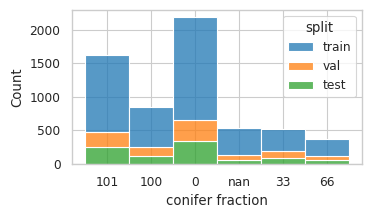

In [92]:
figsize = (7.48031 / 2, 2)
g = sns.histplot(data=results["linear"].reset_index(), x="C_qfrac", hue="split", stat="count", multiple="stack", discrete=True)
g.set(xlabel="conifer fraction")
fig = plt.gcf()
fig.set_size_inches(figsize)
#plt.savefig("figures/c_qfrag_hist.svg")

## boxplot comparing NFI over conifer fractions

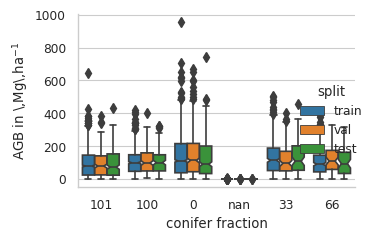

In [94]:
figsize = (7.48031 / 2, 2.5)
g = sns.catplot(data=results["linear"].reset_index(), y="BMag_ha", x="C_qfrac", kind="box", hue="split", notch=True)
g.set(xlabel="conifer fraction")
g.set(ylabel="AGB in \,Mg\,ha$^{-1}$")
fig = plt.gcf()
fig.set_size_inches(figsize)
fig.tight_layout()
#plt.savefig("figures/frac_agb.svg")

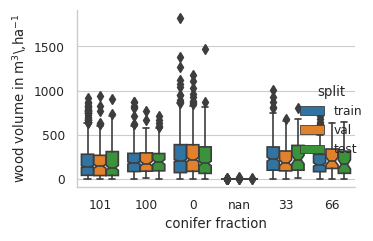

In [95]:
figsize = (7.48031 / 2, 2.5)
g = sns.catplot(data=results["linear"].reset_index(), y="V_ha", x="C_qfrac", kind="box", hue="split", notch=True)
g.set(xlabel="conifer fraction")
g.set(ylabel="wood volume in m$^3$\,ha$^{-1}$")
fig = plt.gcf()
fig.set_size_inches(figsize)
fig.tight_layout()
#plt.savefig("figures/frac_volume.svg")

## boxplot comparing MSENet and NFI over fractions

In [96]:
df_pred = results_corrected["MSENet14"].query("split == 'test'").reset_index().copy()
df_pred["method"] = 'MSENet14'
df_pred["BMag_ha"] = df_pred["BMag_ha_pred"]
df_pred["V_ha"] = df_pred["V_ha_pred"]
df_pred2 = results_corrected["\power{}"].query("split == 'test'").reset_index().copy()
df_pred2["method"] = '\power{}'
df_pred2["BMag_ha"] = df_pred2["BMag_ha_pred"]
df_pred2["V_ha"] = df_pred2["V_ha_pred"]
df_pred3 = results_corrected["MSENet50"].query("split == 'test'").reset_index().copy()
df_pred3["method"] = 'MSENet50'
df_pred3["BMag_ha"] = df_pred3["BMag_ha_pred"]
df_pred3["V_ha"] = df_pred3["V_ha_pred"]
df_truth = results_corrected["MSENet14"].query("split == 'test'").reset_index().copy()
df_truth["method"] = 'NFI'

df = pd.concat([df_pred, df_pred2, 
                #df_pred3, 
                df_truth])


df = df.query("C_qfrac != 'nan'")
df["C_qfrac"] = df["C_qfrac"].astype(int)

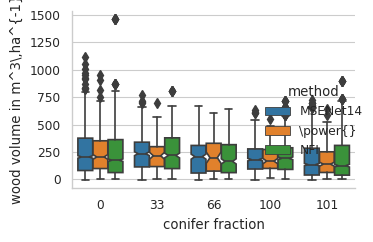

In [97]:
figsize = (7.48031 / 2, 2.5)
g = sns.catplot(data=df, y="V_ha", x="C_qfrac", kind="box", hue="method", notch=True)
g.set(xlabel="conifer fraction")
g.set(ylabel="wood volume in m^3\,ha^{-1}")
#g.set(yscale="log")
fig = plt.gcf()
fig.set_size_inches(figsize)
fig.tight_layout()
#plt.savefig("figures/frac_volume_comp.svg")

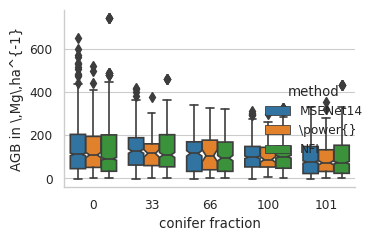

In [98]:
figsize = (7.48031 / 2, 2.5)
g = sns.catplot(data=df, y="BMag_ha", x="C_qfrac", kind="box", hue="method", notch=True)
g.set(xlabel="conifer fraction")
g.set(ylabel="AGB in \,Mg\,ha^{-1}")
fig = plt.gcf()
fig.set_size_inches(figsize)
fig.tight_layout()
#plt.savefig("figures/frac_agb_comp.svg")

In [101]:
def evaluate_species(name, results, split):
    print(name)
    columns = ["method", "target", "C_qfrac", "value", "metric", "run"]
    
    results = results.query("split == @split")
    
    results["Cag_ha"] = results["BMag_ha"] * 0.47
    results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
        
    results_df = []
    for target in target_vars:
        for run, result in results.groupby("run"):
            C_qfracs = set(result.C_qfrac)
            mask = result[target] != 0
            for qfrac in C_qfracs:
                frac_mask = result.C_qfrac == qfrac
                if frac_mask.sum() == 0:
                    continue
                results_df.append(
                    pd.DataFrame(
                        [
                            [
                                name,
                                target,
                                qfrac,
                                r2_score(
                                    result[frac_mask][target],
                                    result[frac_mask][target+"_pred"],
                                ),
                                "R2",
                                run,
                            ]
                        ],
                        columns=columns,
                    )
                )
                results_df.append(
                    pd.DataFrame(
                        [
                            [
                                name,
                                target,
                                qfrac,
                                mean_squared_error(
                                    result[frac_mask][target],
                                    result[frac_mask][target+"_pred"],
                                    squared=False,
                                ),
                                "RMSE",
                                run,
                            ]
                        ],
                        columns=columns,
                    )
                )
                results_df.append(
                    pd.DataFrame(
                        [
                            [
                                name,
                                target,
                                qfrac,
                                mean_absolute_percentage_error(
                                    result[frac_mask & mask][target],
                                    result[frac_mask & mask][target+"_pred"],
                                )
                                * 100,
                                "MAPE",
                                run,
                            ]
                        ],
                        columns=columns,
                    )
                )
    return pd.concat(results_df, axis=0)

In [102]:
result_scores_cfrac = {}
for split in splits:
    result_score = []
    for name in models.keys():
        result_dict[name] = file

        scores = evaluate_species(name, results_corrected[name], split)
        result_score.append(scores)
    result_score = pd.concat(result_score, axis=0)
    result_score = result_score.query("C_qfrac != 'nan'")
    result_score["C_qfrac"] = result_score["C_qfrac"].astype(int)
    result_scores_cfrac[split] = result_score

linear
RF


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

KPConv
PointNet


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

\power{}
MSENet14


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

MSENet50
linear_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

RF_treeval
\power{}_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

KPConv_treeval
PointNet_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

MSENet14_treeval
MSENet50_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

linear
RF
KPConv


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

PointNet
\power{}
MSENet14


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

MSENet50
linear_treeval
RF_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

\power{}_treeval
KPConv_treeval
PointNet_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

MSENet14_treeval
MSENet50_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

linear
RF
KPConv


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

PointNet
\power{}
MSENet14


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

MSENet50
linear_treeval
RF_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

\power{}_treeval
KPConv_treeval
PointNet_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

MSENet14_treeval
MSENet50_treeval


/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_42898/276587871.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47
/tmp/ipykernel_42898/276587871.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [103]:
pd.set_option("display.max_rows", None)
for split in splits:
    print(split)
    display(
        result_scores_cfrac[split]
        .groupby(
            [
                "target",
                "C_qfrac",
                "metric",
                "method",
            ],
            sort=True,
            as_index=False,
        )["value"]
        .mean()
        .pivot(index=["target", "C_qfrac", "method"], columns=["metric"])
    )

train


value                 
metric                                 MAPE      R2     RMSE
target  C_qfrac method                                      
BMag_ha 0       KPConv             374.6228  0.7879  55.9159
                KPConv_treeval    1222.2404  0.7176  63.8283
                MSENet14           357.0664  0.7947  55.0272
                MSENet14_treeval   322.7238  0.7940  55.1264
                MSENet50           474.1587  0.7794  57.1103
                MSENet50_treeval   469.8702  0.7785  57.2248
                PointNet          1075.7263  0.6680  70.0579
                PointNet_treeval  1120.3939  0.6588  71.0236
                RF                 664.5506  0.6872  68.0115
                RF_treeval        7388.1675  0.3729  96.3007
                \power{}           677.3419  0.6562  71.3079
                \power{}_treeval 13318.9384  0.3321  99.3840
                linear            1062.9882  0.6718  69.6684
                linear_treeval    6325.3191  0.3979  94.3655
        33      KPConv              49.8777  0.8175  44.4828
                KPConv_treeval      62.1022  0.7610  50.0162
                MSENet14            55.9861  0.8372  41.9658
                MSENet14_treeval    44.5279  0.8342  42.3487
                MSENet50            59.7646  0.8312  42.8003
                MSENet50_treeval    62.4084  0.8296  43.0044
                PointNet            86.0533  0.7278  54.3584
                PointNet_treeval    85.5342  0.7112  55.9890
                RF                  91.7592  0.7216  54.9777
                RF_treeval         514.0759  0.4008  80.6557
                \power{}           108.4841  0.7186  55.2698
                \power{}_treeval   458.5898  0.2551  89.9315
                linear              70.6966  0.7051  56.5878
                linear_treeval     436.6532  0.4145  79.7319
        66      KPConv              45.3480  0.8211  33.5294
                KPConv_treeval      57.3454  0.7894  36.0695
                MSENet14            48.7037  0.8318  32.5518
                MSENet14_treeval    43.7127  0.8322  32.5081
                MSENet50            50.4514  0.8087  34.7096
                MSENet50_treeval    53.0526  0.8112  34.4847
                PointNet            62.8621  0.7269  41.4939
                PointNet_treeval    73.1128  0.7049  43.1428
                RF                  59.2932  0.7256  41.6017
                RF_treeval         223.1343  0.0311  78.1727
                \power{}            66.5487  0.7028  43.2948
                \power{}_treeval   332.0502 -0.1984  86.9403
                linear              63.0417  0.7106  42.7254
                linear_treeval     173.3806  0.1119  74.8453
        100     KPConv              45.4546  0.7062  40.8768
                KPConv_treeval      57.0534  0.6060  46.8419
                MSENet14            42.8986  0.7338  38.9256
                MSENet14_treeval    42.0540  0.7304  39.1778
                MSENet50            47.7278  0.7100  40.6361
                MSENet50_treeval    45.5546  0.7062  40.9045
                PointNet            68.2957  0.6749  43.0369
                PointNet_treeval    70.6930  0.6611  43.9330
                RF                  68.2138  0.6973  41.5248
                RF_treeval         441.2907 -0.0693  78.0501
                \power{}            62.6262  0.6582  44.1299
                \power{}_treeval   263.7134 -0.3159  86.5819
                linear             104.0196  0.6627  43.8370
                linear_treeval     451.5604 -0.0947  78.9698
        101     KPConv             454.0000  0.7658  39.8251
                KPConv_treeval    1253.1682  0.7062  44.2901
                MSENet14           370.6372  0.7822  38.4141
                MSENet14_treeval   368.3995  0.7786  38.7274
                MSENet50           466.2730  0.7680  39.6512
                MSENet50_treeval   485.5497  0.7650  39.9078
                PointNet          1010.5266  0.7123  44.1623
            

val


value                 
metric                                MAPE      R2     RMSE
target  C_qfrac method                                     
BMag_ha 0       KPConv            804.7858  0.7547  63.8309
                KPConv_treeval    576.0741  0.6945  70.7592
                MSENet14          446.1004  0.7704  61.7558
                MSENet14_treeval  376.2580  0.7658  62.3754
                MSENet50          703.4458  0.7621  62.8652
                MSENet50_treeval  703.9774  0.7588  63.3022
                PointNet         1611.7213  0.6515  76.0939
                PointNet_treeval 1654.4582  0.6391  77.4405
                RF                924.3233  0.6887  71.9182
                RF_treeval       7470.6341  0.3986  99.9654
                \power{}          727.6689  0.6739  73.6097
                \power{}_treeval 3606.8854  0.3884 100.8134
                linear            473.8977  0.6684  74.2345
                linear_treeval   7580.0355  0.4061  99.3420
        33      KPConv            126.9758  0.7511  48.8300
                KPConv_treeval    167.2071  0.7178  51.8262
                MSENet14          101.7451  0.7863  45.2657
                MSENet14_treeval  100.9017  0.7902  44.8564
                MSENet50          114.5345  0.7870  45.2197
                MSENet50_treeval  112.1770  0.7925  44.6263
                PointNet          229.9933  0.7188  51.9652
                PointNet_treeval  229.0861  0.7058  53.1498
                RF                247.3921  0.8326  40.1019
                RF_treeval        623.2916  0.4268  74.2055
                \power{}          347.8201  0.8094  42.7924
                \power{}_treeval 2631.4121  0.3754  77.4635
                linear            284.1087  0.8222  41.3230
                linear_treeval    638.7469  0.4262  74.2462
        66      KPConv             36.1128  0.7397  43.7282
                KPConv_treeval     36.2796  0.6510  50.2197
                MSENet14           32.1003  0.7826  40.0265
                MSENet14_treeval   29.3824  0.7841  39.8832
                MSENet50           34.0637  0.7734  40.8590
                MSENet50_treeval   32.9816  0.7782  40.4295
                PointNet           43.9019  0.6640  49.7441
                PointNet_treeval   46.6554  0.6580  50.1903
                RF                 36.0597  0.6856  48.1408
                RF_treeval        238.0866  0.0879  81.9933
                \power{}           39.2681  0.6167  53.1544
                \power{}_treeval  296.8905 -0.1911  93.7010
                linear             36.9882  0.6970  47.2561
                linear_treeval    196.3496  0.1682  78.3018
        100     KPConv             33.7157  0.7649  36.3041
                KPConv_treeval     36.2852  0.7043  40.1052
                MSENet14           33.3702  0.7811  34.9987
                MSENet14_treeval   33.1610  0.7836  34.8044
                MSENet50           31.4689  0.7986  33.6059
                MSENet50_treeval   31.6737  0.7911  34.2236
                PointNet           39.2163  0.7197  39.6459
                PointNet_treeval   39.2598  0.7154  39.9497
                RF                 29.0405  0.7753  35.5112
                RF_treeval        140.2106 -0.1510  80.3693
                \power{}           32.9568  0.7213  39.5450
                \power{}_treeval  173.3453 -0.5329  92.7506
                linear             31.4765  0.7451  37.8251
                linear_treeval    131.0684 -0.1248  79.4501
        101     KPConv            136.5259  0.8101  34.0605
                KPConv_treeval    191.4706  0.7320  39.7428
                MSENet14          113.4861  0.8192  33.2394
                MSENet14_treeval  119.7173  0.8201  33.1538
                MSENet50          159.1982  0.8271  32.5048
                MSENet50_treeval  155.8107  0.8255  32.6540
                PointNet          487.0619  0.6953  43.1507
                PointNet_treeval  503.4694  0.6983  42.9364
                R

test


value                 
metric                                 MAPE      R2     RMSE
target  C_qfrac method                                      
BMag_ha 0       KPConv             113.7307  0.7795  55.5312
                KPConv_treeval     174.9903  0.7118  62.8864
                MSENet14           120.0068  0.8182  50.4434
                MSENet14_treeval   107.8485  0.8183  50.4226
                MSENet50           165.7227  0.8063  52.0664
                MSENet50_treeval   159.7468  0.8069  51.9793
                PointNet           280.6255  0.7494  59.2245
                PointNet_treeval   280.4503  0.7479  59.4101
                RF                 525.0187  0.7347  60.9495
                RF_treeval        2006.2937  0.4353  88.9206
                \power{}           567.6982  0.7439  59.8803
                \power{}_treeval  3790.5411  0.2753 100.7281
                linear             421.4709  0.7486  59.3251
                linear_treeval    2041.3796  0.4503  87.7271
        33      KPConv              37.8753  0.7547  48.2156
                KPConv_treeval      69.6822  0.6556  56.5580
                MSENet14            36.0272  0.7332  50.2557
                MSENet14_treeval    36.8039  0.7346  50.1321
                MSENet50            35.4646  0.7622  47.4598
                MSENet50_treeval    33.3031  0.7764  46.0203
                PointNet            45.0247  0.6452  57.9907
                PointNet_treeval    47.2673  0.6352  58.8029
                RF                  37.2780  0.6857  54.5893
                RF_treeval         441.1636  0.1323  90.6949
                \power{}            38.4741  0.6906  54.1601
                \power{}_treeval   405.3648  0.1498  89.7779
                linear              39.5112  0.6903  54.1861
                linear_treeval     418.7693  0.1979  87.2009
        66      KPConv              60.0866  0.8018  34.8103
                KPConv_treeval     136.2317  0.7394  39.6866
                MSENet14            54.3685  0.8244  32.7850
                MSENet14_treeval    49.2067  0.8185  33.3328
                MSENet50            58.5416  0.8396  31.3105
                MSENet50_treeval    56.3370  0.8366  31.5929
                PointNet            96.7167  0.7610  38.2226
                PointNet_treeval   132.8200  0.7860  36.1788
                RF                  85.2849  0.7279  40.8137
                RF_treeval         638.6087  0.0153  77.6468
                \power{}            55.3033  0.7225  41.2167
                \power{}_treeval  1246.9583 -0.5146  96.2992
                linear              51.3584  0.7363  40.1812
                linear_treeval     537.6381  0.1705  71.2671
        100     KPConv              61.0229  0.7966  34.6517
                KPConv_treeval     143.9263  0.6811  42.9693
                MSENet14            41.4986  0.8282  31.8774
                MSENet14_treeval    39.2539  0.8267  32.0152
                MSENet50            50.9461  0.8316  31.5574
                MSENet50_treeval    71.0517  0.8205  32.5835
                PointNet            85.3918  0.7754  36.4519
                PointNet_treeval    86.6778  0.7678  37.0703
                RF                  93.1104  0.8018  34.2500
                RF_treeval         355.1950 -0.1053  80.8893
                \power{}            99.8429  0.8106  33.4873
                \power{}_treeval   476.1943 -0.2032  84.3959
                linear              94.4681  0.8039  34.0701
                linear_treeval     522.7593 -0.0885  80.2702
        101     KPConv            1241.2882  0.8132  36.3953
                KPConv_treeval    1122.7415  0.7304  42.9605
                MSENet14           698.1485  0.8167  36.0585
                MSENet14_treeval   551.3003  0.8114  36.5736
                MSENet50           947.8311  0.8335  34.3580
                MSENet50_treeval   839.5544  0.8263  35.0886
                PointNet          2308.1891  0.7837  39.1815
            

# Errors Cancel Out

In [104]:
def spatial_aggregate(
    name: str,
    results,
    split,
    max_n_samples: int,
    n_steps: int,
    n_start: 1,
    seed: int = 42,
    n_repetitions: int = 10,
):
    print(name)
    columns = ["method", "target", "n_samples", "i_repeat", "value", "metric", "run"]
    
    results = results.query("split == @split")
    
    results["Cag_ha"] = results["BMag_ha"] * 0.47
    results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47

    results_df = []
    for target in ["Cag_ha"]:
        for run, result in results.groupby("run"):
            for n_samples in range(n_start, max_n_samples, n_steps):
                # if n_samples == 0:
                #     n_samples = 1
                n_splits = len(result) / n_samples
                if n_splits < 10:
                    print(f"less than 10 samples possible with n_samples = {n_samples}")
                    break
                for i_repeat in range(n_repetitions):
                    # aggregate
                    index = np.linspace(0, n_splits, len(result)).astype(int)
                    rs = np.random.RandomState(seed + i_repeat)
                    rs.shuffle(index)

                    agg_results = result.copy().select_dtypes(include=np.number)
                    # set aggregate index
                    agg_results["agg"] = index
                    # ignore overhanging samples
                    agg_results.query(f"agg < {int(n_splits)}", inplace=True)

                    agg_results = agg_results.groupby("agg").apply(
                        lambda x: x.sum() / n_samples
                    )

                    mask = agg_results[target] != 0

                    results_df.append(
                        pd.DataFrame(
                            [
                                [
                                    name,
                                    target,
                                    n_samples,
                                    i_repeat,
                                    r2_score(agg_results[target], agg_results[target+"_pred"]),
                                    "R2",
                                    run,
                                ]
                            ],
                            columns=columns,
                        )
                    )
                    results_df.append(
                        pd.DataFrame(
                            [
                                [
                                    name,
                                    target,
                                    n_samples,
                                    i_repeat,
                                    mean_squared_error(
                                        agg_results[target],
                                        agg_results[target+"_pred"],
                                        squared=False,
                                    ),
                                    "RMSE",
                                    run,
                                ]
                            ],
                            columns=columns,
                        )
                    )
                    results_df.append(
                        pd.DataFrame(
                            [
                                [
                                    name,
                                    target,
                                    n_samples,
                                    i_repeat,
                                    mean_absolute_percentage_error(
                                        agg_results[mask][target],
                                        agg_results[mask][target+"_pred"],
                                    )
                                    * 100,
                                    "MAPE",
                                    run,
                                ]
                            ],
                            columns=columns,
                        )
                    )
                    if n_samples == 1:
                        break
    return pd.concat(results_df, axis=0)

In [58]:
result_scores_agg = {}
for split in ["test"]:
    result_score = []
    for name in models.keys():
        result_dict[name] = file
        scores = spatial_aggregate(name, results_corrected[name], split, 91, 1, 1)
        result_score.append(scores)
    result_score = pd.concat(result_score, axis=0)
    result_scores_agg[split] = result_score

linear


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


RF


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


KPConv


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


PointNet


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


\power{}


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


MSENet14


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


MSENet50


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


MSENet14_xy_treeadd


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


MSENet50_xy_treeadd


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


linear_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


RF_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


\power{}_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


KPConv_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


PointNet_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


MSENet14_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


MSENet50_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


MSENet14_xy_treeadd_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


MSENet50_xy_treeadd_treeval


/tmp/ipykernel_2805/1353084170.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha"] = results["BMag_ha"] * 0.47
/tmp/ipykernel_2805/1353084170.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["Cag_ha_pred"] = results["BMag_ha_pred"] * 0.47


In [59]:
with open('result_scores_agg.pickle', 'wb') as handle:
    pickle.dump(result_scores_agg, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [105]:
with open('result_scores_agg.pickle', 'rb') as handle:
    result_scores_agg = pickle.load(handle)

In [108]:
hue_order = [
    "linear",
    "linear_treeval",
    "\power{}",
    "\power{}_treeval",
    "RF",
    "RF_treeval",
    "PointNet",
    "PointNet_treeval",
    "KPConv",
    "KPConv_treeval",
    "MSENet14",
    "MSENet14_treeval",
    "MSENet50",
    "MSENet50_treeval",
]
hue_order = hue_order[1::2]
palette = sns.color_palette("Set2", n_colors=len(hue_order))

In [110]:
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451)]

In [111]:
treevals = result_scores_agg["test"]["method"].str.contains("treeval")
rs = result_scores_agg["test"].query("target == 'Cag_ha' & metric == 'RMSE' & @treevals")

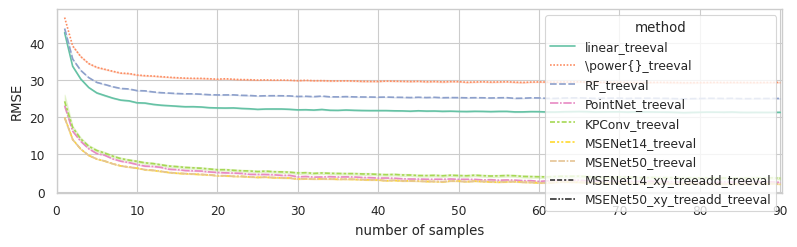

In [113]:
# RMSE
figsize = (7.48031, 2.1)
g = sns.lineplot(
    data=rs,
    x="n_samples",
    y="value",
    style="method", 
    hue="method",
    hue_order=hue_order,
    palette=palette,
    orient="x",
    errorbar="se",
    #err_style="bars",
    #err_kws={"capsize": 3},
    dashes=True
)
g.set(xlim=(1, 90.25))
g.set(xticks=np.arange(0, 91, 10))
# g.set(ylim=(0, 26.5))
g.set(ylabel="RMSE")
g.set(xlabel="number of samples")
# sns.despine(left=True, right=True, top=False)
fig = plt.gcf()
fig.set_size_inches(figsize)
plt.subplots_adjust(left=0.03, right=1, top=1, bottom=0.125, hspace=0.15, wspace=0.1)
#plt.savefig("figures/spatial_agg_RMSE_carbon.svg")

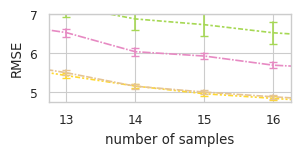

In [114]:
# RMSE 2
figsize = (7.48031 / 3, 1)
g = sns.lineplot(
    data=rs,
    x="n_samples",
    y="value",
    style="method", hue="method",
    hue_order=hue_order,
    palette=palette,
    orient="x",
    errorbar="se",
    err_style="bars",
    dashes=True,
    err_kws={"capsize": 3},
    legend=False
)
# sns.despine(left=True, right=True, top=False)
g.set(ylabel="RMSE")
g.set(xlabel="number of samples")
g.set(xlim=(12.75, 16.25))
g.set(xticks=np.arange(13, 17, 1))
g.set(ylim=(4.75, 7))
fig = plt.gcf()
fig.set_size_inches(figsize)
plt.subplots_adjust(left=0.03, right=1, top=1, bottom=0.125, hspace=0.15, wspace=0.1)
#plt.savefig("figures/spatial_agg_RMSE_zoom_carbon.svg")

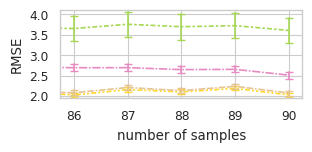

In [115]:
# RMSE 3
figsize = (7.48031 / 3, 1)
g = sns.lineplot(
    data=rs,
    x="n_samples",
    y="value",
    style="method", hue="method",
    hue_order=hue_order,
    palette=palette,
    orient="x",
    errorbar="se",
    err_style="bars",
    dashes=True,
    err_kws={"capsize": 3},
    legend=False
)
# sns.despine(left=True, right=True, top=False)
g.set(ylabel="RMSE")
g.set(xlabel="number of samples")
g.set(xlim=(85.75, 90.25))
g.set(xticks=np.arange(86, 91, 1))
g.set(ylim=(1.95, 4.1))
g.set(yticks=np.arange(2., 4.1, .5))
fig = plt.gcf()
fig.set_size_inches(figsize)
plt.subplots_adjust(left=0.03, right=1, top=1, bottom=0.125, hspace=0.15, wspace=0.1)
#plt.savefig("figures/spatial_agg_RMSE_zoom2_carbon.svg")

# Plots

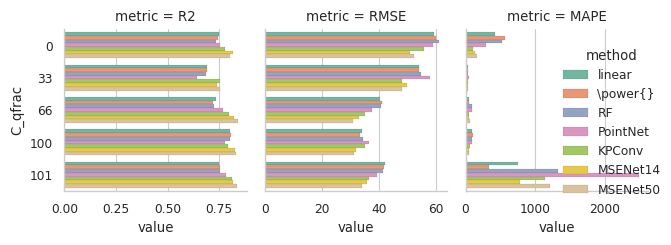

In [117]:
figsize = (6.556, 1.750)
g = sns.catplot(
    data=result_scores_cfrac["test"].query("target == 'BMag_ha'"),
    x="value",
    y="C_qfrac",
    hue="method",
    hue_order=[
        "linear",
        "\power{}",
        "RF",
        "PointNet",
        "KPConv",
        "MSENet14",
        "MSENet50",
    ],
    col="metric",
    kind="bar",
    palette=sns.color_palette("Set2", n_colors=7),
    legend_out=True,
    height=1.750,
    orient="h",
    sharex=False,
    edgecolor=".0",
    linewidth=0.05,
    errorbar=None,
    estimator=np.median,
)
# g.set(xlim=(0.5, 1.01))
fig = plt.gcf()
fig.set_size_inches(figsize)
plt.subplots_adjust(left=0.08, right=0.97, top=1, bottom=0.075, hspace=0.15, wspace=0.1)
#plt.savefig("figures/species_bplot_b.svg")

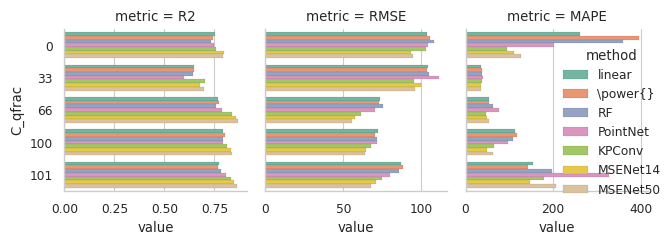

In [118]:
figsize = (6.556, 1.750)
g = sns.catplot(
    data=result_scores_cfrac["test"].query("target == 'V_ha'"),
    x="value",
    y="C_qfrac",
    hue="method",
    hue_order=[
        "linear",
        "\power{}",
        "RF",
        "PointNet",
        "KPConv",
        "MSENet14",
        "MSENet50",
    ],
    col="metric",
    kind="bar",
    palette=sns.color_palette("Set2", n_colors=7),
    legend_out=True,
    height=1.750,
    orient="h",
    sharex=False,
    edgecolor=".0",
    linewidth=0.05,
    errorbar=None,
    estimator=np.median,
)
# g.set(xlim=(0.5, 1.01))
fig = plt.gcf()
fig.set_size_inches(figsize)
plt.subplots_adjust(left=0.08, right=0.97, top=1, bottom=0.075, hspace=0.15, wspace=0.1)
#plt.savefig("figures/species_bplot_v.svg")

In [119]:
target = "BMag_ha"

In [122]:
dff = []
"""
df_ensemble = df_test.copy()
df_ensemble["method"] = "ensemble"
for target in target_vars:
    df_ensemble[f"{target}_pred"] = 0
ensemble_member = ["Minkowski", "KPConv", "PointNet", "exp.\ model"]
"""
best = {
    "MSENet14": 0,
    "MSENet50": 3,
    "KPConv": 4,
    "PointNet": 4,
    "RF": 3,
    "linear": 0,
    "\power{}": 0,
}
for name, split in product(models, ["test"]):
    if "treeval" in name:
        continue
    dfr = results_corrected[name].query(f"run == {best[name]} & split == @split").reset_index(drop=True).copy()
    dfr["method"] = name
    """
    if name in ensemble_member:
        for target in target_vars:
            df_ensemble[f"{target}_pred"] += dfr[f"{target}_pred"] * (
                1.0 / len(ensemble_member)
            )
    """
    dff.append(dfr)
# dff.append(df_ensemble)

dff = pd.concat(dff, axis=0)

KPConv
MSENet14
MSENet50
PointNet
RF
\power{}
linear


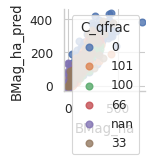

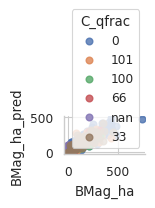

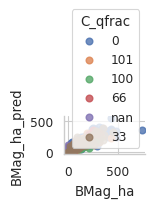

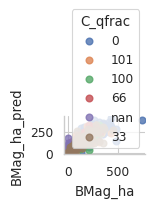

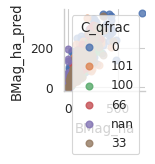

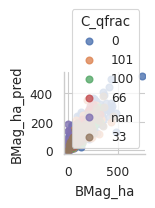

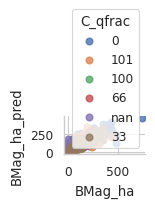

In [123]:
for target in target_vars:
    for group, group_df in dff.groupby("method"):
        print(group)
        sns.set(
            rc={"figure.figsize": (3.28125003459, 4)},
            context="paper",
            style="whitegrid",
        )

        f = sns.lmplot(
            x=target,
            y=f"{target}_pred",
            hue="C_qfrac",
            height=3.28125003459 / 2,
            data=group_df,
            fit_reg=False,
            facet_kws={"legend_out": False},
        )
        #         f.ax.set_title(group)
        plt.tight_layout()
    break

BMag_ha
linear
RF
KPConv
PointNet
\power{}
MSENet14
MSENet50


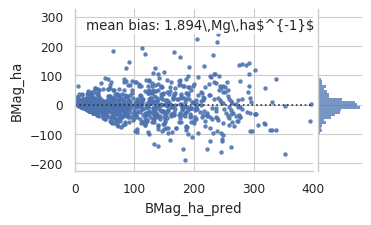

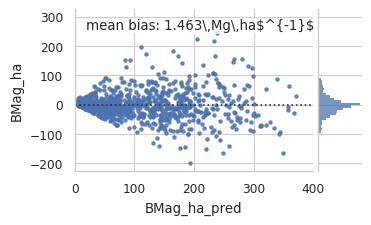

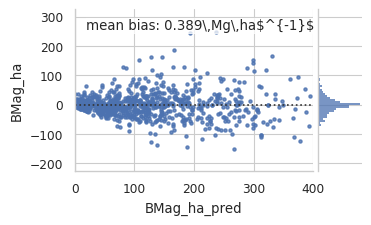

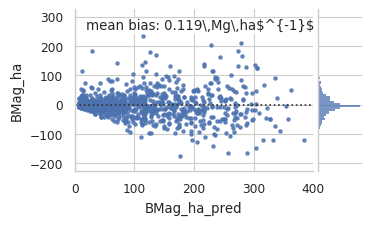

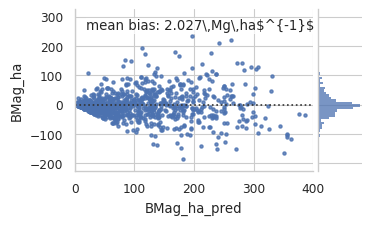

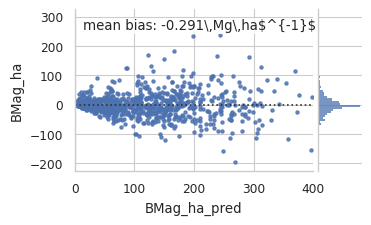

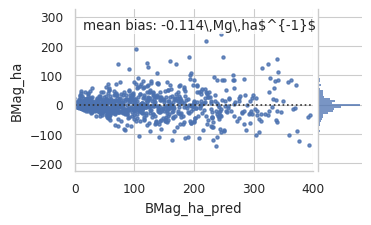

In [125]:
figsize = (3.28125003459, 1.8)
sns.set(
    rc={"figure.figsize": figsize}, context="paper", style="whitegrid", font_scale=0.75
)

max_dict = {
    "BMag_ha": 400,
    "V_ha": 1000,
}

y_range = {
    "BMag_ha": (-225, 325),
    "V_ha": (-310, 440),
}

y_unit = {
    "BMag_ha": "\,Mg\,ha\$^{-1}\$",
    "V_ha": "\,m$^3\$\,ha\$^-1\$",
}


split = "test"

for target in ["BMag_ha"]: #target_vars:
    print(target)
    #     if target != "BMag_ha": continue
    for method in result_scores[split].method.unique():
        #         f, ax = plt.subplots()
        run_i = best[method]
        dff = results_corrected[method].query(f"run == {run_i} & split == @split")
        if len(dff) == 0: continue
        print(method)
        sns.set(
            rc={"figure.figsize": figsize},
            context="paper",
            style="whitegrid",
            font_scale=1,
        )
        y_min, y_max = y_range[target]
        #y_max = (dff[target] - dff[f"{target}_pred"]).max()
        #y_min = (dff[target] - dff[f"{target}_pred"]).min()
        x_min = 0
        x_max = max_dict[target]

        #         n_bins = 500//10
        #         bins = np.linspace(0, 500, n_bins+1)#np.histogram_bin_edges(dff[target], n_bins, range=(0,500))
        #         err = abs(dff[target] - group_df[f"{target}_pred"]).values
        #         bin_err = []
        #         bin_x = []
        #         for i in range(n_bins):
        #             mask = (bins[i] <= dff[target]) & (dff[target] < bins[i+1])
        #             err_ = err[mask].std()
        #             err_ = 0 if np.isnan(err_) else err_
        #             bin_err.append(err_)
        #             bin_err.append(err_)
        #             bin_x.append(bins[i])
        #             bin_x.append(bins[i+1])
        #         bin_err = np.array(bin_err)

        #         ax.fill_between(bin_x, -bin_err, bin_err, alpha=0.5, color="g")

        #         ax.scatter(group_df[target], group_df[target] - group_df[f"{target}_pred"], s=5, label=group)

        f = sns.jointplot(
            y=target,
            x=f"{target}_pred",
            kind="resid",
            data=dff,
            #             label=group,
            robust=False,
            scatter_kws={"s": 5},
            marginal_kws={"edgecolor": ".0", "linewidth": 0.00},
        )
        #         f.ax_joint.legend()

        #         f.ax_marg_x.set_title(group)
        fig = plt.gcf()
        fig.delaxes(f.ax_marg_x)
        fig.set_size_inches(figsize)
        # plt.title(method)
        plt.subplots_adjust(
            left=0.125, right=1, top=1.2, bottom=0.12, hspace=0.1, wspace=0.1
        )
        me = (
            result_scores[split]
            .query(f"method == '{method}' & target == '{target}' & corrected == True & run == {run_i} & not treeval")[
                "mean bias"
            ]
            .median()
        )
        f.ax_joint.text(
            0.525,
            0.9,
            f"mean bias: {me:0.3f}{y_unit[target]}",
            horizontalalignment="center",
            verticalalignment="center",
            transform=f.ax_joint.transAxes,
            bbox={"facecolor": "white", "alpha": 0.75, "pad": .1},
        )
        f.ax_joint.set_xlim((x_min, x_max))
        f.ax_joint.set_ylim((y_min, y_max))
        f.ax_marg_y.set_ylim((y_min, y_max))
        f.ax_marg_y.margins(y=0.01)
        f.ax_marg_x.margins(x=0)
        f.ax_joint.margins(y=0.01, x=0)
        group_name = method.replace(" ", "").replace("\\", "").replace("{}", "")
        #plt.savefig(f"figures/{target}_{group_name}_resid.svg")